In [1]:
import sympy as sp
from sympy import symbols, sin, cos, Matrix, Eq, Rational, floor, sqrt
from sympy import simplify, factorial, pi, binomial, factor, expand, collect
from sympy.functions.special.tensor_functions import KroneckerDelta
from sympy import init_printing
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import *
import pandas as pd
from sympy import latex
from scipy.optimize import curve_fit
from IPython.display import display, Math

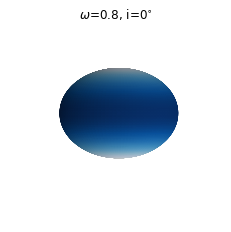

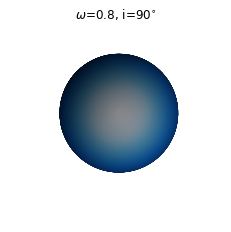

In [2]:
import plot_spheroid as ps #code I wrote to plot a spheroid, adapted from Gdit (Aaron Dotter)
ps.plot_one_spheroid_inc(omega=0.8,inc=0,figname=None)
ps.plot_one_spheroid_inc(omega=0.8,inc=90,figname=None)

# Gravity-darkened intensity using Von Zeipel Law:

We need to find a function $F(x,y)$ which gives us the flux of the star at different x and y positions on the projected surface of the star.

We can use the Von Zeipel Law: $$T = T_{pole} \frac{g^{\beta}}{g_{pole}^{\beta}}$$

Where $T_{pole}$ is the temperature at the pole, $\beta$ is a scaling parameter, and $T$ and $g$ are the temperature and stellar surface gravity at a given point on the stellar surface. We can plug this into a blackbody equation to obtain flux. We can then plug the Von Zeipel Law into a simple blackbody equation to find the flux: 

$$F = \sigma T^4$$

***
Let's use Von Zeipel's Law as a function of x, y, z on the stellar surface. [Barnes et al. 2009](https://arxiv.org/pdf/0909.1752.pdf) has the math for this. 
Let's call x0, y0, and z0 the x, y and z components on the stellar surface *with no obliquity* relative to us. ie, this is the simple case where the star's rotation axis is parallel to the y axis. 

In [3]:
x0, y0, z0= sp.symbols("x0 y0 z0",real=True,positive=True) #can switch positive=True off, but sympy simplifies better
Omega, R, R_perp, G, M, beta, T_pole, g_pole = sp.symbols(
    "Omega R R_perp G M beta T_pole g_pole"
    ,real=True,positive=True)
R = sqrt(x0**2+y0**2+z0**2)
R_perp = sqrt(x0**2+z0**2)
R_vec = Matrix([x0/R,y0/R,z0/R])
R_perpvec = Matrix([x0/R_perp,0,  z0/R_perp])
g_vec = -(G*M/R**2)*R_vec + Omega**2*R_perp*R_perpvec
display(Math(r'\vec{g} = '+latex(g_vec)))

<IPython.core.display.Math object>

Also, $\Omega$, the angular rotational velocity, can be written as a dimensionless variable $\omega$ based on the prescription: $$ \omega = \Omega \sqrt{\frac{R_{eq}^3}{GM}}$$

In [4]:
R_eq, omega = sp.symbols("R_eq, omega",positive=True,real=True)
g_vec = g_vec.subs([(Omega,omega/sqrt(G*M/R_eq**3))])
display(Math(r'\vec{g} = ' + latex(g_vec)))

<IPython.core.display.Math object>

Now let's write this into the Von Zeipel Law. $\beta$ is a number around 0.25 for the slow rotating case and [Lara and Rieutord 2011](https://www.aanda.org/articles/aa/pdf/2011/09/aa17252-11.pdf) have theoretical values for $\beta$ for different amounts of flatteing:

In [5]:
g_pole = g_vec.subs([(x0,0),(y0,R_eq),(z0,0)])
T = T_pole * (g_vec.norm()/g_pole.norm())**beta
display(Math('T = ' + latex(T)))

<IPython.core.display.Math object>

Assuming a spherical star, the equation for the star's photosphere would be: 
$$ x_0^2 + y_0^2 +z_0^2 = R_{eq}^2$$

where $x_0, y_0, z_0$ are in coordinates such that the star's rotation axis is the y axis. Now, z0 can be found as $$z_0 = \sqrt{R_{eq}^2 - x_0^2 -y_0^2}$$

In [6]:
T_simp = (T_pole * (simplify(g_vec.norm().subs([(z0,sqrt(1 - x0**2 - y0**2))]))/g_pole.norm())**beta)
display(Math('T = ' + latex(T_simp)))

<IPython.core.display.Math object>

Finally, plug the temperature into the blackbody equation to find the flux. Also replace $T_{pole}$ with $F_{pole}$ for convenience:

In [7]:
F, F_pole, sigma = sp.symbols("F F_pole sigma",real=True,positive=True)
F_pole = (sigma*(T_simp.subs([(x0,0),(y0,1),(z0,0),(g_pole,G*M)]))**4)
F = sigma*T_simp**4/F_pole
display(Math('F = F_{pole} ' + latex(F)))

<IPython.core.display.Math object>

As expected, all the x's drop out! The star's temperature and flux are only functions of y because the star's rotation axis is aligned with the y axis.

## Rotation about $\varphi$

Now, the true coordinates are of course, not so simple. The entire star could be inclined by an angle $\varphi$. In order to model, this, we use the following expression:

In [8]:
varphi = sp.symbols('varphi', real=True)
rot = Matrix([[1,0,0],[0,cos(varphi),sin(varphi)],[0,-sin(varphi),cos(varphi)]])
display(Math(r'\vec{x_0} = ' + latex(rot)+r'\vec{x}'))

<IPython.core.display.Math object>

In [9]:
x, y, z = sp.symbols('x, y, z', real=True,positive=True) #can switch positive=True off, but sympy simplifies better
x_vec = Matrix([x,y,z])
x0_vec = Matrix([rot.row(0).dot(x_vec),rot.row(1).dot(x_vec),rot.row(2).dot(x_vec)])
display(Math(r'\begin{bmatrix}x_0\\y_0\\z_0\end{bmatrix} = ' + latex(x0_vec)))

<IPython.core.display.Math object>

Now we know from above that $$z_0 = \sqrt{R_{eq}^2 - x_0^2 -y_0^2}$$ still, so let's perform a substitution:

In [10]:
eq1 = Eq(x0**2+y0**2+z0**2,R_eq**2).subs([(x0,rot.row(0).dot(x_vec)),(y0,rot.row(1).dot(x_vec)),(z0,rot.row(2).dot(x_vec))])
z_soln = sp.solve(eq1,z)[0]
display(Math(r'z = ' + latex(z_soln)))

<IPython.core.display.Math object>

In [11]:
F_rot = F.subs([(x0,rot.row(1).dot(x_vec)),(y0,rot.row(1).dot(x_vec)),(z0,z_soln)])
F_rot = simplify(F_rot.subs([(z,z_soln)]))
display(Math(r'F(x,y,\varphi) = F_{pole}' + latex(F_rot)))

<IPython.core.display.Math object>

Now, for the slow rotating case, $\beta$ is often taken as 0.25. Let's see what happens if we take $\beta = 0.25$, it will simplify things a bit.

In [12]:
display(Math(r'F(x,y,\varphi) = F_{pole}' + latex(F_rot.subs([(beta,Rational(1/4))]))))

<IPython.core.display.Math object>

# Spherical Harmonic Expansion:
Now we must try to express this analytically in the polynomial basis as done by Luger et al. in the radial velocity field expansion. However, we can see that this will be impossible analytically, because the beta term in the Von Zeipel Law breaks everything.

The great thing, though, is that you *can* rotate the star to a convenient position to write the spherical harmonic expansion, and then rotate the resulting expansion however you like. In this case, because the star is axisymmetric about the y axis in the trivial case, we can rotate so that the star is pole on, and write the expansion with m=0.

Remember this is how a pole on star looks:

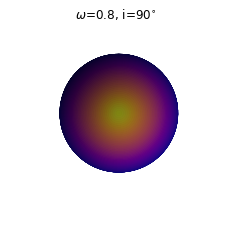

In [13]:
ps.plot_one_spheroid_inc(omega=0.8,inc=90,figname=None)

Now simplify by setting $R_{eq}$ to 1 and rotating the star to pole on:

In [14]:
F_poleon = collect(
        collect(
            collect(
                expand(F_rot.subs([(varphi,pi/2),(R_eq,1)])),x**2)
            ,y**2),
    (-2*G**2*M**2*omega**2+omega**4))
display(Math(r'F(x,y,\varphi) = F_{pole}' + latex(F_poleon)))

<IPython.core.display.Math object>

Wow!! In pole on configuration, the math looks so much simpler! In fact, I think this is just exaggerated limb darkening. We are so close to a polynomial expansion now, we just need to get rid of the $2\beta$. We can simplify this further to write it as a binomial to the power of $\beta$:

In [15]:
r, alpha = sp.symbols("r alpha",real=True)
F_poleon = sp.powsimp(F_poleon, force=True)
alpha_current = (G**4*M**4+(x**2+y**2)*(-2*G**2*M**2*omega**2+omega**4))**2
alpha_new = G**8*M**8*(1+(x**2+y**2)*(-2*omega**2/(G**2*M**2) + omega**4/(G**4*M**4)))**2
F_poleon = F_poleon.subs([(alpha_current,alpha_new)])
display(Math(r'F(x,y,\varphi) = F_{pole}' + latex(F_poleon)))

<IPython.core.display.Math object>

Finally, setting $$\alpha = \left(- \frac{2 \omega^{2}}{G^{2} M^{2}} + \frac{\omega^{4}}{G^{4} M^{4}}\right)$$

In [16]:
F_poleon = F_poleon.subs([((-2*omega**2/(G**2*M**2) + omega**4/(G**4*M**4)),alpha)])
display(Math(r'F(x,y,\varphi) = F_{pole}' + latex(F_poleon)))

<IPython.core.display.Math object>

## Binomial Expansion:

Now, this is a proper expression for a binomial expansion! Let's display the expansion to 2nd order:

In [17]:
order_approx = 2 #set the highest order of the approximation

def binomial_exp(x,k,n):
    assert k==int(k)
    return binomial(n,k)*x**(k)
f = 0

for i in range(order_approx+1):
    print(binomial_exp(x=(alpha*(x**2+y**2)),k=i,n=2*beta).expand(func=True))
    f+=binomial_exp(x=(alpha*(x**2+y**2)),k=i,n=2*beta).expand(func=True)
f #highest exponent here goes as 2*(n)

1
2*alpha*beta*x**2 + 2*alpha*beta*y**2
2*alpha**2*beta**2*x**4 + 4*alpha**2*beta**2*x**2*y**2 + 2*alpha**2*beta**2*y**4 - alpha**2*beta*x**4 - 2*alpha**2*beta*x**2*y**2 - alpha**2*beta*y**4


2*alpha**2*beta**2*x**4 + 4*alpha**2*beta**2*x**2*y**2 + 2*alpha**2*beta**2*y**4 - alpha**2*beta*x**4 - 2*alpha**2*beta*x**2*y**2 - alpha**2*beta*y**4 + 2*alpha*beta*x**2 + 2*alpha*beta*y**2 + 1

In [18]:
def poly_basis(n, x, y):
    """Return the n^th term in the polynomial basis."""
    l = Rational(floor(sqrt(n)))
    m = Rational(n - l * l - l)
    mu = Rational(l - m)
    nu = Rational(l + m)
    if nu % 2 == 0:
        i = Rational(mu, 2)
        j = Rational(nu, 2)
        k = Rational(0)
    else:
        i = Rational(mu - 1, 2)
        j = Rational(nu - 1, 2)
        k = Rational(1)
    return x ** i * y ** j * sqrt(1 - x ** 2 - y ** 2) ** k


# Compute the polynomial basis
basis = Matrix([poly_basis(n, x, y) for n in range((2*order_approx+1)**2)]).T #need (2*order_approx-2)**2 terms to correctly model

def Coefficient(expression, term):
    """Return the coefficient multiplying `term` in `expression`."""
    # Get the coefficient
    coeff = expression.coeff(term)
    # Set any non-constants in this coefficient to zero. If the coefficient
    # is not a constant, this is not the term we are interested in!
    coeff = coeff.subs(sqrt(1 - x ** 2 - y ** 2), 0).subs(x, 0).subs(y, 0)
    return coeff


vec = Matrix([Coefficient(expand(f), term) for term in basis])
vec

Matrix([
[                                   1],
[                                   0],
[                                   0],
[                                   0],
[                        2*alpha*beta],
[                                   0],
[                                   0],
[                                   0],
[                        2*alpha*beta],
[                                   0],
[                                   0],
[                                   0],
[                                   0],
[                                   0],
[                                   0],
[                                   0],
[  2*alpha**2*beta**2 - alpha**2*beta],
[                                   0],
[                                   0],
[                                   0],
[4*alpha**2*beta**2 - 2*alpha**2*beta],
[                                   0],
[                                   0],
[                                   0],
[  2*alpha**2*beta**2 - alpha**

Now check if the above polynomial accurately models the function:

In [19]:
simplify(factor(basis.dot(vec)) - f) == 0

True

## Conversion to spherical coordinates:

In [20]:
def SA(l, m):
    """A spherical harmonic normalization constant."""
    return sqrt(
        (2 - KroneckerDelta(m, 0))
        * (2 * l + 1)
        * factorial(l - m)
        / (4 * pi * factorial(l + m))
    )


def SB(l, m, j, k):
    """Another spherical harmonic normalization constant."""
    try:
        ratio = factorial(Rational(l + m + k - 1, 2)) / factorial(
            Rational(-l + m + k - 1, 2)
        )
    except ValueError:
        ratio = 0
    res = (
        2 ** l
        * Rational(
            factorial(m),
            (factorial(j) * factorial(k) * factorial(m - j) * factorial(l - m - k)),
        )
        * ratio
    )
    return simplify(res)


def SC(p, q, k):
    """Return the binomial theorem coefficient `C`."""
    res = factorial(Rational(k, 2)) / (
        factorial(Rational(q, 2))
        * factorial(Rational(k - p, 2))
        * factorial(Rational(p - q, 2))
    )
    return simplify(res)


def Y(l, m, x, y):
    """Return the spherical harmonic of degree `l` and order `m`."""
    res = 0
    z = sqrt(1 - x ** 2 - y ** 2)
    if m >= 0:
        for j in range(0, m + 1, 2):
            for k in range(0, l - m + 1, 2):
                for p in range(0, k + 1, 2):
                    for q in range(0, p + 1, 2):
                        res += (
                            (-1) ** ((j + p) // 2)
                            * SA(l, m)
                            * SB(l, m, j, k)
                            * SC(p, q, k)
                            * x ** (m - j + p - q)
                            * y ** (j + q)
                        )
            for k in range(1, l - m + 1, 2):
                for p in range(0, k, 2):
                    for q in range(0, p + 1, 2):
                        res += (
                            (-1) ** ((j + p) // 2)
                            * SA(l, m)
                            * SB(l, m, j, k)
                            * SC(p, q, k - 1)
                            * x ** (m - j + p - q)
                            * y ** (j + q)
                            * z
                        )
    else:
        for j in range(1, abs(m) + 1, 2):
            for k in range(0, l - abs(m) + 1, 2):
                for p in range(0, k + 1, 2):
                    for q in range(0, p + 1, 2):
                        res += (
                            (-1) ** ((j + p - 1) // 2)
                            * SA(l, abs(m))
                            * SB(l, abs(m), j, k)
                            * SC(p, q, k)
                            * x ** (abs(m) - j + p - q)
                            * y ** (j + q)
                        )
            for k in range(1, l - abs(m) + 1, 2):
                for p in range(0, k, 2):
                    for q in range(0, p + 1, 2):
                        res += (
                            (-1) ** ((j + p - 1) // 2)
                            * SA(l, abs(m))
                            * SB(l, abs(m), j, k)
                            * SC(p, q, k - 1)
                            * x ** (abs(m) - j + p - q)
                            * y ** (j + q)
                            * z
                        )

    return res


def p_Y(l, m, lmax):
    """Return the polynomial basis representation of the spherical harmonic `Y_{lm}`."""
    ylm = Y(l, m, x, y)
    res = [ylm.subs(sqrt(1 - x ** 2 - y ** 2), 0).subs(x, 0).subs(y, 0)]
    for n in range(1, (lmax + 1) ** 2):
        res.append(Coefficient(ylm, poly_basis(n, x, y)))
    return res


def A1(lmax, norm=2 / sqrt(pi)):
    """Return the change of basis matrix A1. The columns of this matrix are given by `p_Y`."""
    res = sp.zeros((lmax + 1) ** 2, (lmax + 1) ** 2)
    n = 0
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            res[n] = p_Y(l, m, lmax)
            n += 1
    return res * norm

In [21]:
change_basis_sph = Matrix(A1(2*(order_approx))).inv()
ycoeffs = simplify(change_basis_sph * vec)
ycoeffs

Matrix([
[pi*(8*alpha**2*beta*(2*beta - 1) + 20*alpha*beta + 15)/15],
[                                                        0],
[                                                        0],
[                                                        0],
[                                                        0],
[                                                        0],
[4*sqrt(5)*pi*alpha*beta*(-8*alpha*beta + 4*alpha - 7)/105],
[                                                        0],
[                                                        0],
[                                                        0],
[                                                        0],
[                                                        0],
[                                                        0],
[                                                        0],
[                                                        0],
[                                                        0],
[              

In [22]:
ycoeffs.subs([(alpha,((-2*omega**2/(G**2*M**2) + omega**4/(G**4*M**4))))])

Matrix([
[                                        pi*(8*beta*(2*beta - 1)*(-2*omega**2/(G**2*M**2) + omega**4/(G**4*M**4))**2 + 20*beta*(-2*omega**2/(G**2*M**2) + omega**4/(G**4*M**4)) + 15)/15],
[                                                                                                                                                                                      0],
[                                                                                                                                                                                      0],
[                                                                                                                                                                                      0],
[                                                                                                                                                                                      0],
[                                                       

In [23]:
ycoeffs = ycoeffs.subs([(alpha,((-2*omega**2/(G**2*M**2) + omega**4/(G**4*M**4))))])

**If all was done correctly, this should be the spherical harmonic expansion of gravity darkening to 2nd order!**

***
***

## Starry maps

Now let's create a real map of the surface of a gravity-darkened star. We'll use this to generatee transit models. 

In [110]:
%matplotlib inline
import starry
import numpy as np

starry.config.lazy = False
starry.config.quiet = True

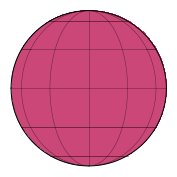

In [111]:
map0 = starry.Map(ydeg=2*order_approx)
map0.show()

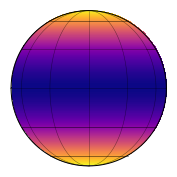

In [112]:
arr = []
for i in ycoeffs:
    arr.append(float(i.evalf(subs={G:1, M:1, omega:0.60,beta:0.22}))) #use G=1, M=1, omegaa = 0.60
arr = np.array(arr)
map0[1:,:] = arr[1:]/arr[0]

map0.rotate(axis=[1,0,0],theta=90)
map0.show()

Now let's see thee poles of the star:

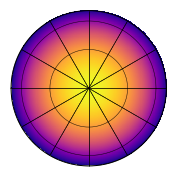

In [113]:
map0.obl = 0
map0.inc = 0
map0.show()

And an animation of the star rotating:

In [114]:
theta = np.linspace(0, 360, 50)
map0.inc = 90
map0.show(theta=theta)

Now let's create a hot-Jupiter planet:

In [127]:
star = starry.Primary(map0, m=1.0, r=1.0, prot=1.0)

planet = starry.kepler.Secondary(
    starry.Map(ydeg=5, amp=5e-3),  # the surface map
    m=0,  # mass in solar masses
    r=0.1,  # radius in solar radii
    porb=3.23,  # orbital period in days
    inc=87.3,
    prot=1.0,  # rotation period in days (synchronous)
    Omega=90,  # longitude of ascending node in degrees
    ecc=0.3,  # eccentricity
    w=30,  # longitude of pericenter in degrees
    t0=0,  # time of transit in days
)

We can also incline the star along its axis:

In [128]:
star.map.inc=90
system = starry.System(star, planet)

### Creating lightcurves:

Finally, let's create a lightcurve with the above system:

In [129]:
%%time
time = np.linspace(planet.porb-0.15, planet.porb+0.15, 10000)
flux_star, flux_planet = system.flux(time, total=False)

CPU times: user 1.33 s, sys: 66.4 ms, total: 1.39 s
Wall time: 1.39 s


<IPython.core.display.Javascript object>


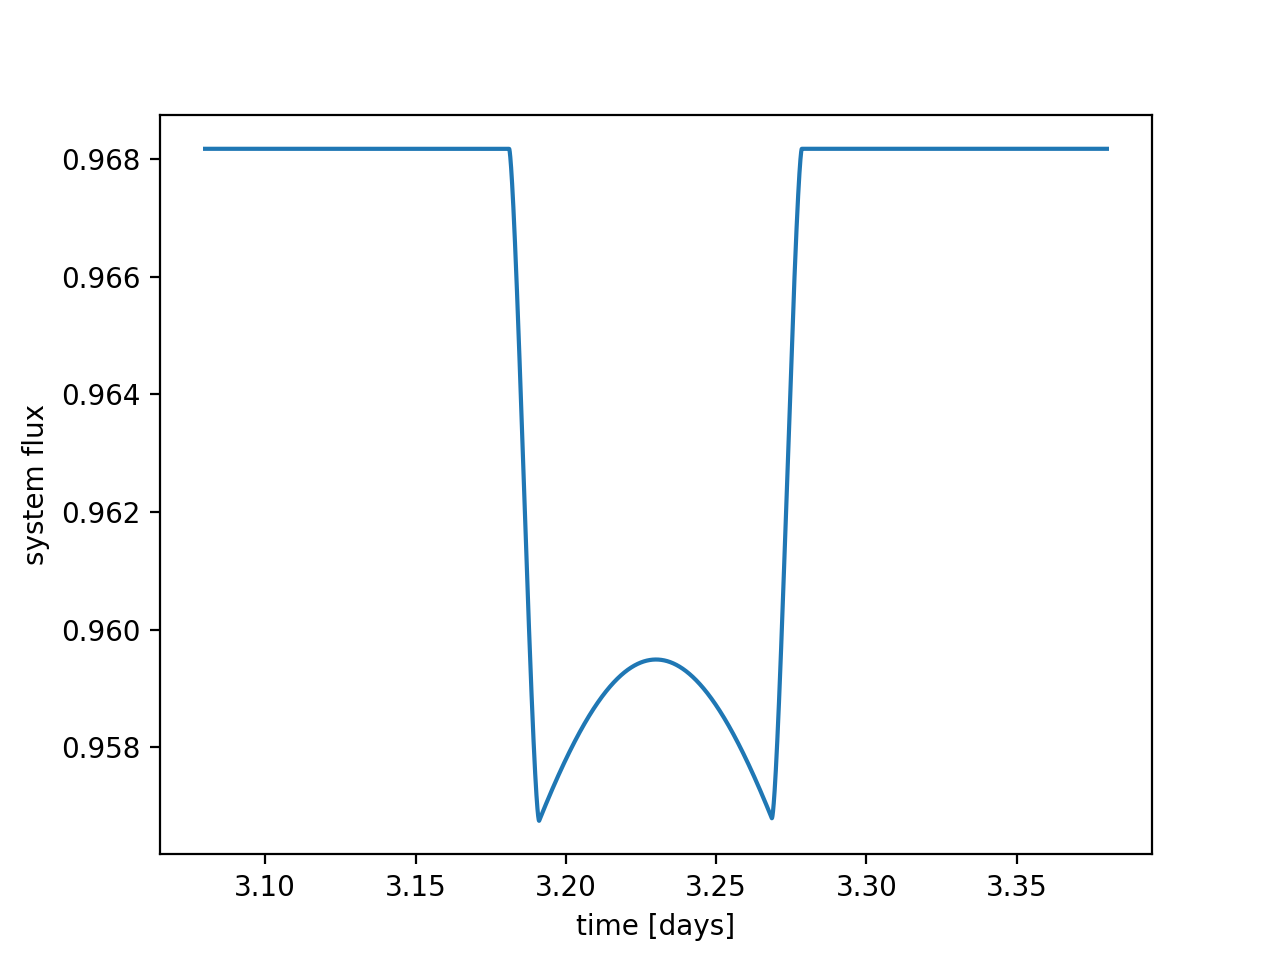

In [130]:
%matplotlib notebook
plt.plot(time, flux_star)
plt.xlabel("time [days]")
plt.ylabel("system flux");

<IPython.core.display.Javascript object>


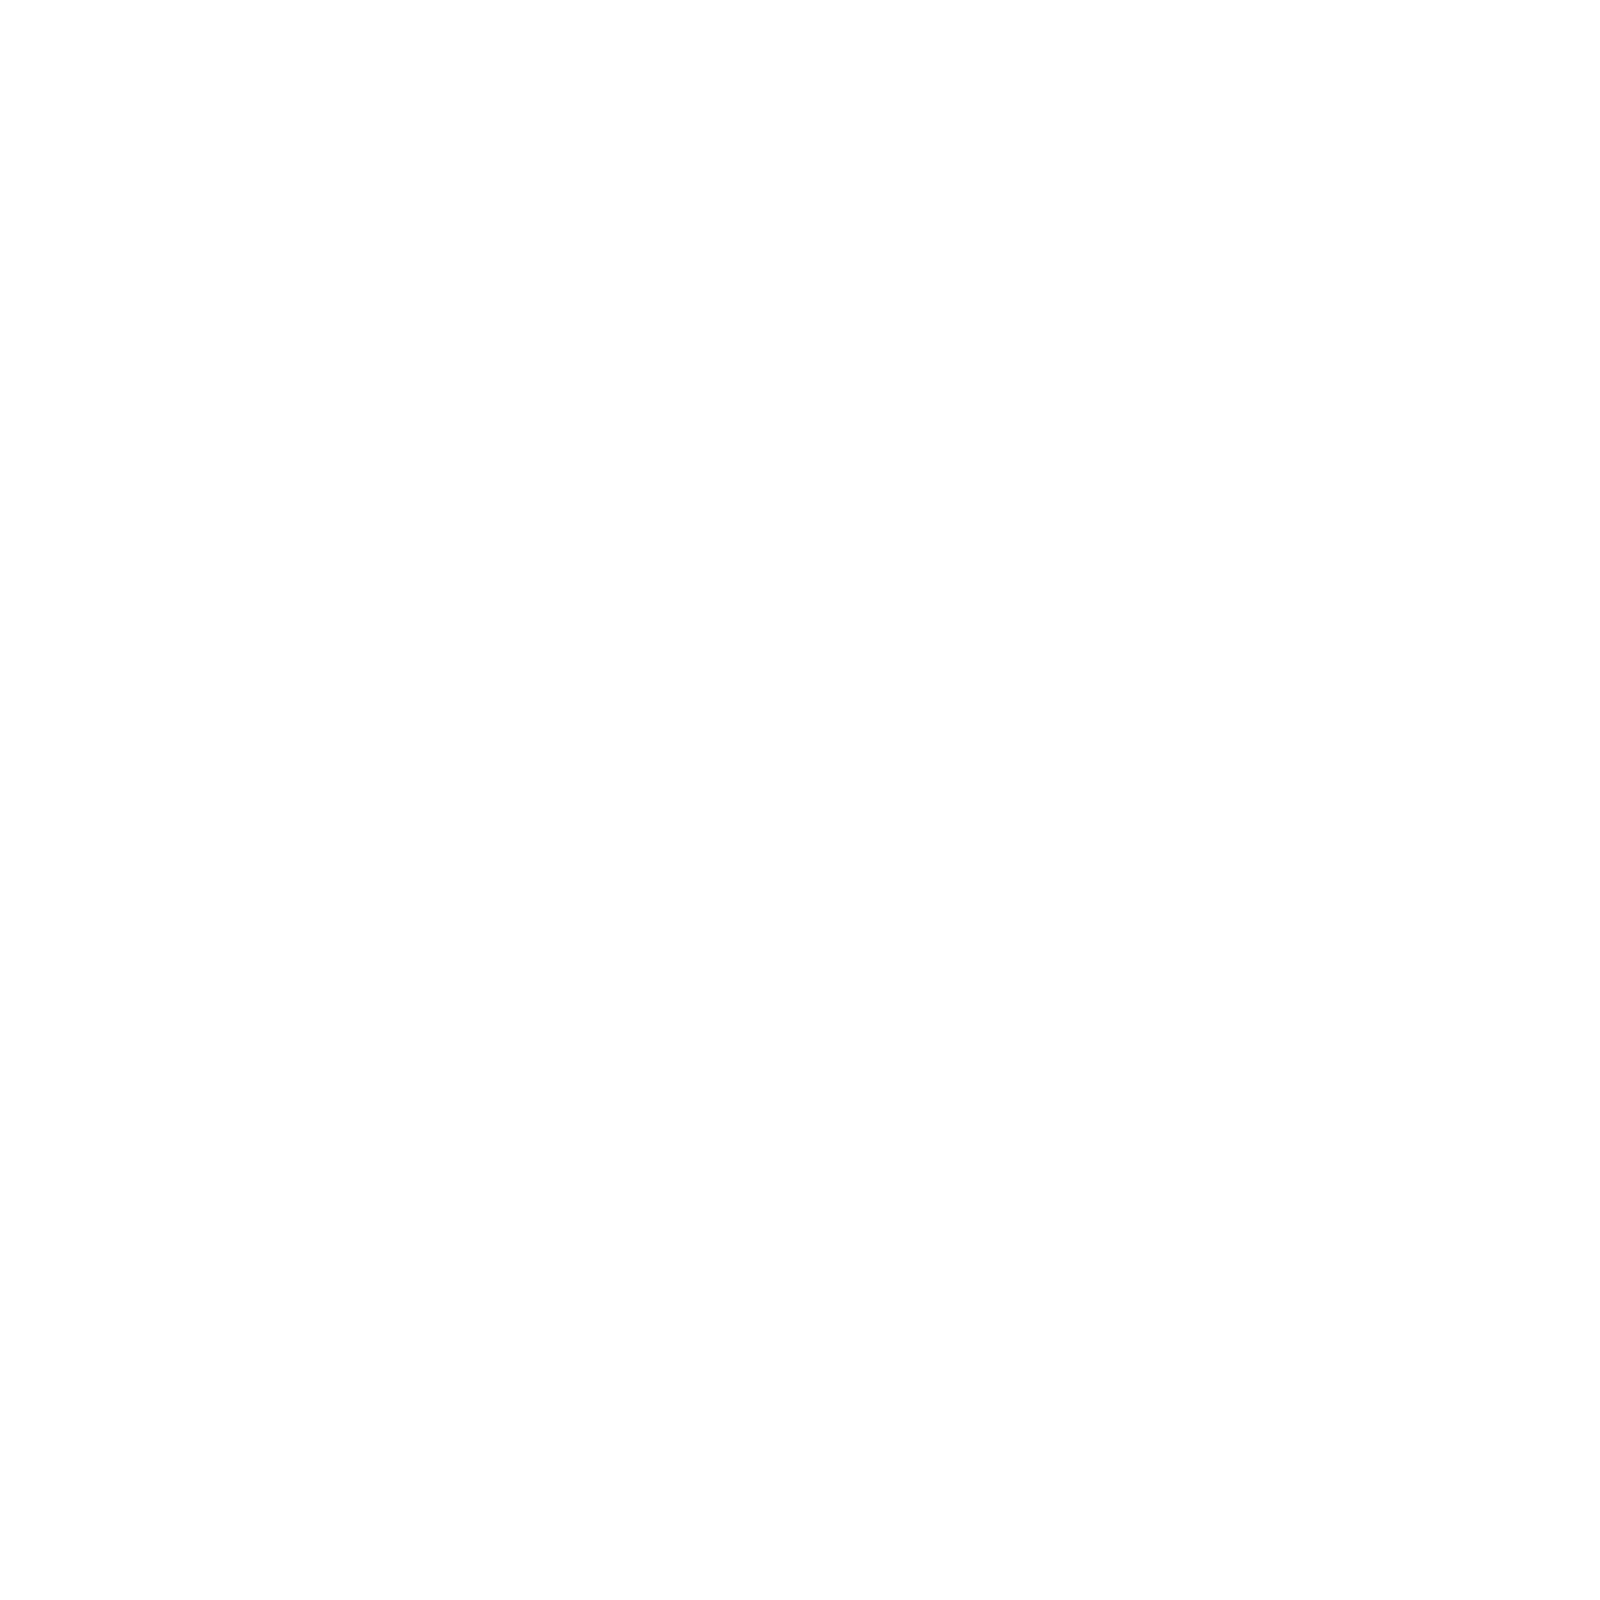

In [131]:
planet.r = 0.33
system.show(t=np.linspace(0, 7, 50), window_pad=8, figsize=(8, 8))